In [4]:
!pip install tensorflow_hub

In [5]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import warnings
import string
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
import gensim.models
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
from tensorflow.keras import initializers, preprocessing, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...


True

## **Learn to classify news group**

In [6]:
from sklearn.datasets import fetch_20newsgroups


categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(
    subset='train', categories=categories,
    shuffle=True, random_state=42)
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'category'])


# **Loading Tensorfow_hub encoder**

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

In [7]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
text_vect = embed(twenty_train.data)

C:\Users\micha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


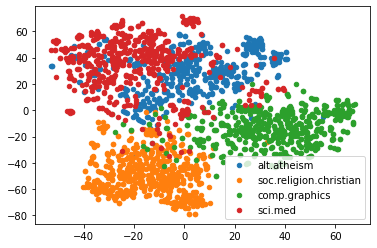

In [8]:
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(text_vect)

for g in range(len(categories)):
  ix=np.where(df_train['category']==g)
  plt.scatter(x_reduced[ix, 0], x_reduced[ix, 1],  label = categories[g], s = 20)
plt.legend()

# **Get Vector Embedding from Sentences**

In [9]:
sentences = df_train["text"].apply(lambda x: x.lower()).tolist()
# generating training data matrix
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist()) 

# Transforming categories label to  one hot encoding
lb = LabelBinarizer().fit(list(set(df_train['category'].tolist())))



# **Prepare the train data and test data**

In [ ]:
# setting up train data and labels (processed)
X, Y = np.array(embed_matrix), lb.transform(df_train['category'].tolist())

# splitting up data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, shuffle=True)

x_train.shape


(1579, 512)

# **Building, train and evaluate the model**

In [ ]:
# Model Architecture
model = Sequential()
model.add(Input(shape=512))
model.add(Dense(units=256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics ='categorical_accuracy') 

#Visualize the model
print(model.summary())

# setting up early stopping callback function (one of the measures to stop when model is over fitting)
# es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# model.fit(x_train, y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[es_callback])


model.fit(x_train, y_train, epochs=10, batch_size=100, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 174,692
Trainable params: 174,692
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
13/13 [===========================

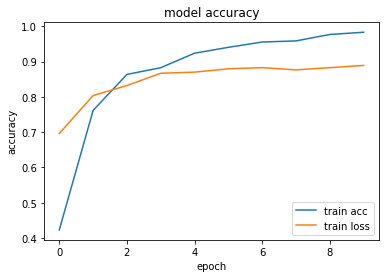

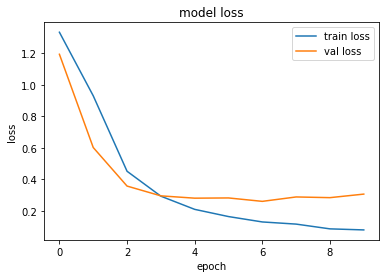

Train: 0.963, Test: 0.906


In [ ]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'train loss'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# **Use the model to predict**

In [ ]:
#check the true label
print('text to predict= \n',df_train['text'].iloc[-1])
print('true label=', df_train['category'].iloc[-1],' ',categories[df_train['category'].iloc[-1]])
print('predicted label=',model.predict(embed([df_train['text'].iloc[-1]]),verbose=0).argmax())

text to predict= 
 From: dyer@spdcc.com (Steve Dyer)
Subject: Re: Is MSG sensitivity superstition?
Organization: S.P. Dyer Computer Consulting, Cambridge MA
Lines: 14

In article <1qnns0$4l3@agate.berkeley.edu> spp@zabriskie.berkeley.edu (Steve Pope) writes:
>The mass of anectdotal evidence, combined with the lack of
>a properly constructed scientific experiment disproving
>the hypothesis, makes the MSG reaction hypothesis the
>most likely explanation for events.

You forgot the smiley-face.

I can't believe this is what they turn out at Berkeley.  Tell me
you're an aberration.

-- 
Steve Dyer
dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer

true label= 2   comp.graphics
predicted label= 2


In [ ]:
y_pred=model.predict(x_test).argmax(axis=1)
print(classification_report(y_test.argmax(axis=1),y_pred))

22/22 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       141
           1       0.96      0.96      0.96       189
           2       0.98      0.93      0.96       184
           3       0.79      0.93      0.86       164

    accuracy                           0.91       678
   macro avg       0.91      0.90      0.90       678
weighted avg       0.91      0.91      0.91       678

